In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA, convert_image
from models import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
scaling_factor = 2
crop_size = 96*scaling_factor
large_kernel_size = 9
small_kernel_size = 3
n_channels = 64
n_blocks = 16
lr_img_type = '[0, 1]'#'gta-small-norm'#
hr_img_type = '[0, 1]'#'[-1, 1]'

batch_size = 16
epochs = 4
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class AdvancedUpscaleNet(nn.Module):
    def __init__(self, upscale_factor=2, num_residuals=8):
        super(AdvancedUpscaleNet, self).__init__()
        self.entry = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residuals)]
        )

        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.out_conv = nn.ConvTranspose2d(
            64, 3, kernel_size=upscale_factor * 2, stride=upscale_factor, padding=upscale_factor // 2
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)
        x = self.conv_mid(x)
        x = torch.sigmoid(self.out_conv(x))
        return x

In [7]:
torch.cuda.empty_cache()
criterion = nn.MSELoss().to(device)
# checkpoint = 'checkpoint_custom_model.pth.tar'
checkpoint = None
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    model = AdvancedUpscaleNet().to(device)
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    start_epoch = 0

In [16]:
losses = []

for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)

    # torch.save({'epoch': epoch+start_epoch,
    #                 'model': model,
    #                 'optimizer': optimizer},
    #                'checkpoint_custom_model.pth.tar')

EPOCH 1


Epoch 1/4: 100%|██████████| 157/157 [01:24<00:00,  1.86it/s, loss=0.000972]


EPOCH 2


Epoch 2/4: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s, loss=0.000874]


EPOCH 3


Epoch 3/4: 100%|██████████| 157/157 [01:40<00:00,  1.56it/s, loss=0.001]   


EPOCH 4


Epoch 4/4: 100%|██████████| 157/157 [01:56<00:00,  1.34it/s, loss=0.00104] 


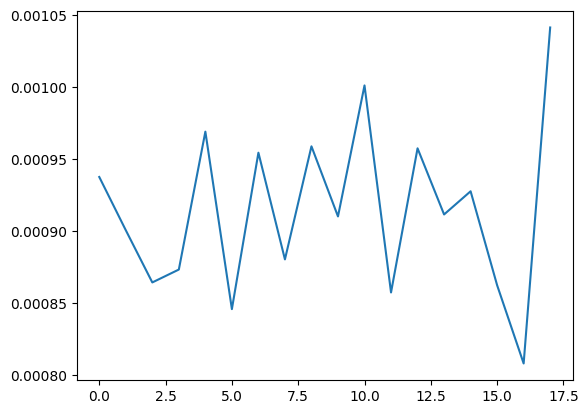

In [18]:
plt.plot(losses[10:])
plt.show()

torch.Size([3, 96, 96])
(192, 192, 3)


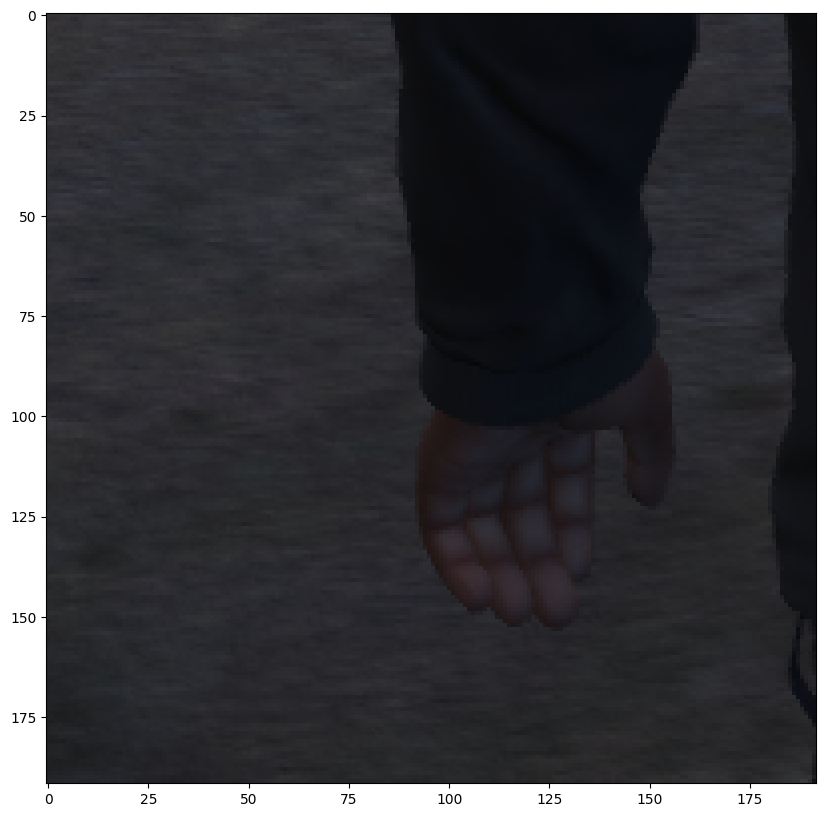

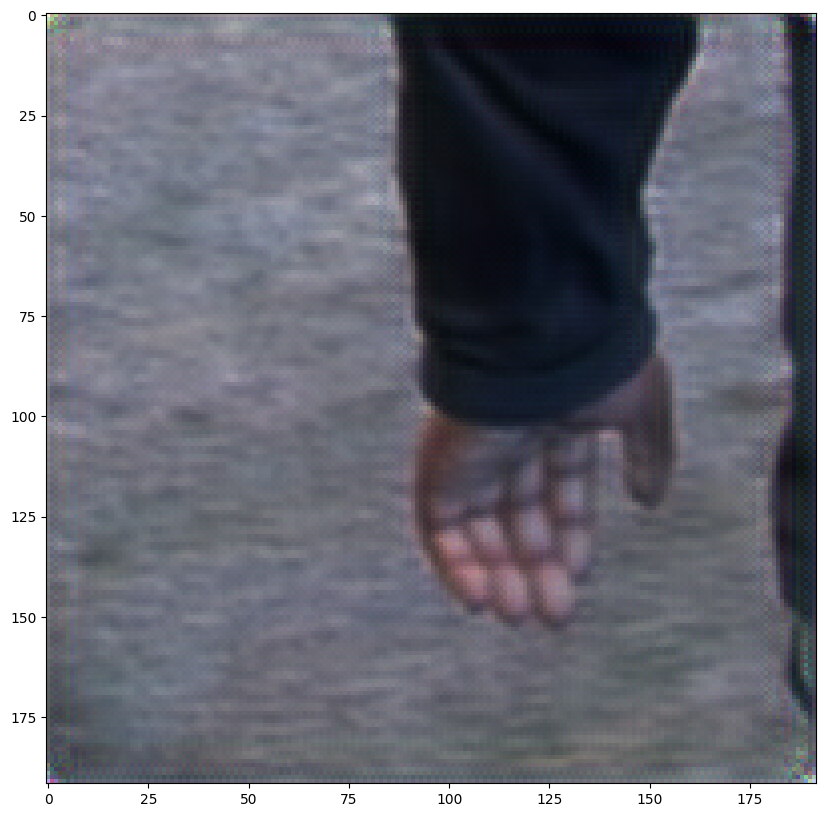

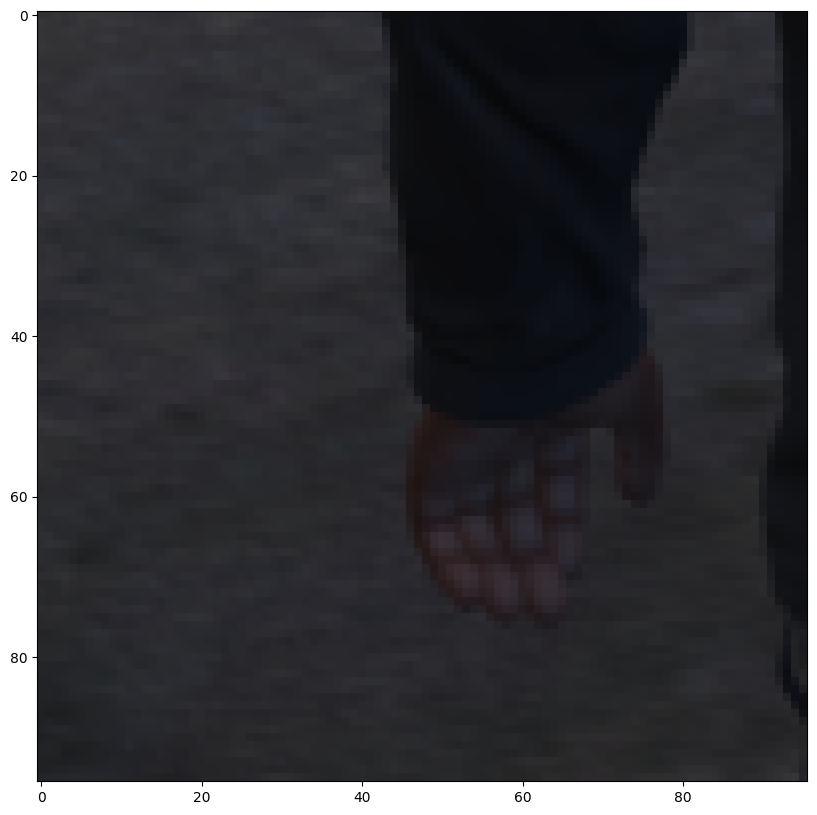

In [17]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        print(lr_img.shape)
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        print(sr_img.shape)
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        sr_img = (((sr_img - np.min(sr_img)) / (np.max(sr_img) - np.min(sr_img)))*255).astype(np.uint8)
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        break

In [20]:
import torchvision.transforms.functional as FT
with torch.no_grad():
    x_hr = training_data.get_full_image(6)

    x_lr = x_hr.resize((int(x_hr.width / 2), int(x_hr.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('out.png',x_sr)

    plt.imsave('in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('high-res.png', np.array(x_hr))

    # Save just the truck for closer inspection
    x_hr_truck = x_hr.crop((400, 300, 660, 474))
    x_lr = x_hr_truck.resize((int(x_hr_truck.width / 2), int(x_hr_truck.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('truck-out.png',x_sr)

    plt.imsave('truck-in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('truck-high-res.png', np.array(x_hr_truck))

    # Save just the sign for closer inspection
    x_hr_sign = x_hr.crop((1720, 172, 1872, 240))
    x_lr = x_hr_sign.resize((int(x_hr_sign.width / 2), int(x_hr_sign.height / 2)),
                               Image.BICUBIC)
    x_lr = FT.to_tensor(x_lr).unsqueeze(0).to(device)
    x_sr = model(x_lr).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
    #x_sr = (((x_sr - np.min(x_sr)) / (np.max(x_sr) - np.min(x_sr)))*255).astype(np.uint8)
    x_sr = np.clip(x_sr, 0, 1)
    plt.imsave('sign-out.png',x_sr)

    plt.imsave('sign-in.png',x_lr.to('cpu').squeeze(0).permute(1, 2, 0).numpy())
    plt.imsave('sign-high-res.png', np.array(x_hr_sign))

In [21]:
torch.save({'epoch': 12,
                'model': model,
                'optimizer': optimizer},
               'checkpoint_custom_model.pth.tar')